[Reference](https://medium.com/@xf600/classifying-and-predicting-stock-market-states-using-hmm-and-xgboost-c23bd4af68ed)

In [2]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 9.6 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
pip install hmmlearn

     |████████████████████████████████| 129 kB 4.8 MB/s 


In [6]:
!pip install backtrader

     |████████████████████████████████| 410 kB 7.5 MB/s 


In [7]:
# HMM
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
# XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
import datetime
# Backtest
from backtrader.feeds import PandasData
import backtrader as bt
import backtrader.analyzers as btanalyzers
# Warning
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Download RUA data from yfinance
df = yf.download('^RUA', start='2002-12-31', end='2021-12-31', progress=False)
df.index = pd.to_datetime(df.index)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-12-31,489.010010,491.059998,483.880005,489.489990,489.489990,0
2003-01-02,489.489990,505.179993,489.489990,505.179993,505.179993,0
2003-01-03,505.179993,506.230011,502.100006,504.769989,504.769989,0
2003-01-06,504.769989,517.530029,504.769989,516.039978,516.039978,0
2003-01-07,516.039978,516.650024,510.769989,512.450012,512.450012,0
...,...,...,...,...,...,...
2021-12-23,2750.840088,2776.620117,2750.840088,2768.360107,2768.360107,0
2021-12-27,2769.340088,2803.879883,2769.340088,2803.739990,2803.739990,0
2021-12-28,2803.899902,2813.590088,2795.709961,2798.350098,2798.350098,0


In [9]:
# Calculate return by using the percentage of close price 
df['Return'] = df['Close'].pct_change()
df

,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
2002-12-31,489.010010,491.059998,483.880005,489.489990,489.489990,0,NaN
2003-01-02,489.489990,505.179993,489.489990,505.179993,505.179993,0,0.032054
2003-01-03,505.179993,506.230011,502.100006,504.769989,504.769989,0,-0.000812
2003-01-06,504.769989,517.530029,504.769989,516.039978,516.039978,0,0.022327
2003-01-07,516.039978,516.650024,510.769989,512.450012,512.450012,0,-0.006957
...,...,...,...,...,...,...,...
2021-12-23,2750.840088,2776.620117,2750.840088,2768.360107,2768.360107,0,0.006490
2021-12-27,2769.340088,2803.879883,2769.340088,2803.739990,2803.739990,0,0.012780
2021-12-28,2803.899902,2813.590088,2795.709961,2798.350098,2798.350098,0,-0.001922


In [10]:
# Select data from 2003-01-02 to 2021-12-30
df = df.loc['2003-01-02':'2021-12-30']
df

,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
2003-01-02,489.489990,505.179993,489.489990,505.179993,505.179993,0,0.032054
2003-01-03,505.179993,506.230011,502.100006,504.769989,504.769989,0,-0.000812
2003-01-06,504.769989,517.530029,504.769989,516.039978,516.039978,0,0.022327
2003-01-07,516.039978,516.650024,510.769989,512.450012,512.450012,0,-0.006957
2003-01-08,512.450012,512.450012,504.529999,505.309998,505.309998,0,-0.013933
...,...,...,...,...,...,...,...
2021-12-23,2750.840088,2776.620117,2750.840088,2768.360107,2768.360107,0,0.006490
2021-12-27,2769.340088,2803.879883,2769.340088,2803.739990,2803.739990,0,0.012780
2021-12-28,2803.899902,2813.590088,2795.709961,2798.350098,2798.350098,0,-0.001922


Text(0, 0.5, 'Close Price')

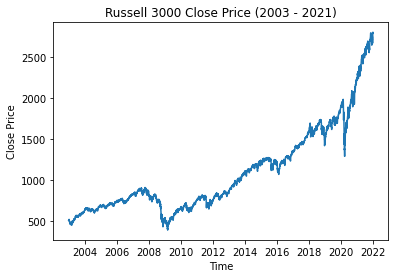

In [11]:
# Plot Russell 3000 close price from 2003 to 2021
plt.plot(df['Close'])
plt.title('Russell 3000 Close Price (2003 - 2021)')
plt.xlabel('Time')
plt.ylabel('Close Price')

Text(0, 0.5, 'Return')

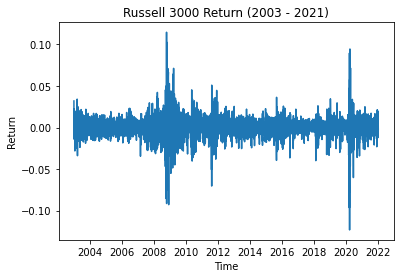

In [12]:
# Plot Russell 3000 return from 2003 to 2021
plt.plot(df['Return'])
plt.title('Russell 3000 Return (2003 - 2021)')
plt.xlabel('Time')
plt.ylabel('Return')

In [13]:
# Regard return as observations
df_new = df.reset_index(inplace=True, drop=False)
df_new = pd.DataFrame(df['Return'])
df_new 

,Return
0,0.032054
1,-0.000812
2,0.022327
3,-0.006957
4,-0.013933
...,...
4749,0.006490
4750,0.012780
4751,-0.001922
4752,0.001258


In [14]:
# Change return from dataframe to list
stock = list(df_new.itertuples(index=False, name=None))

In [15]:
return_val = np.array([i[0] for i in stock])
X = np.column_stack([return_val])
X

array([[ 0.03205378],
       [-0.0008116 ],
       [ 0.02232698],
       ...,
       [-0.00192239],
       [ 0.00125789],
       [-0.00212722]])

In [16]:
# Assume the distribution of emission probabilities is Gaussian, and use HMM to decode states
model = GaussianHMM(n_components=3)
model.fit(X)
hidden_states = model.predict(X)
states = pd.DataFrame(hidden_states)
states.columns = ['state']
states

,state
0,1
1,1
2,1
3,1
4,1
...,...
4749,0
4750,0
4751,0
4752,0


In [17]:
# Combine decoded states with original dataframe
result = pd.concat([df, states], axis=1)
result.set_index(['Date'], inplace=True)
result

,Open,High,Low,Close,Adj Close,Volume,Return,state
Date,,,,,,,,
2003-01-02,489.489990,505.179993,489.489990,505.179993,505.179993,0,0.032054,1
2003-01-03,505.179993,506.230011,502.100006,504.769989,504.769989,0,-0.000812,1
2003-01-06,504.769989,517.530029,504.769989,516.039978,516.039978,0,0.022327,1
2003-01-07,516.039978,516.650024,510.769989,512.450012,512.450012,0,-0.006957,1
2003-01-08,512.450012,512.450012,504.529999,505.309998,505.309998,0,-0.013933,1
...,...,...,...,...,...,...,...,...
2021-12-23,2750.840088,2776.620117,2750.840088,2768.360107,2768.360107,0,0.006490,0
2021-12-27,2769.340088,2803.879883,2769.340088,2803.739990,2803.739990,0,0.012780,0
2021-12-28,2803.899902,2813.590088,2795.709961,2798.350098,2798.350098,0,-0.001922,0


Text(0, 0.5, 'Close Price')

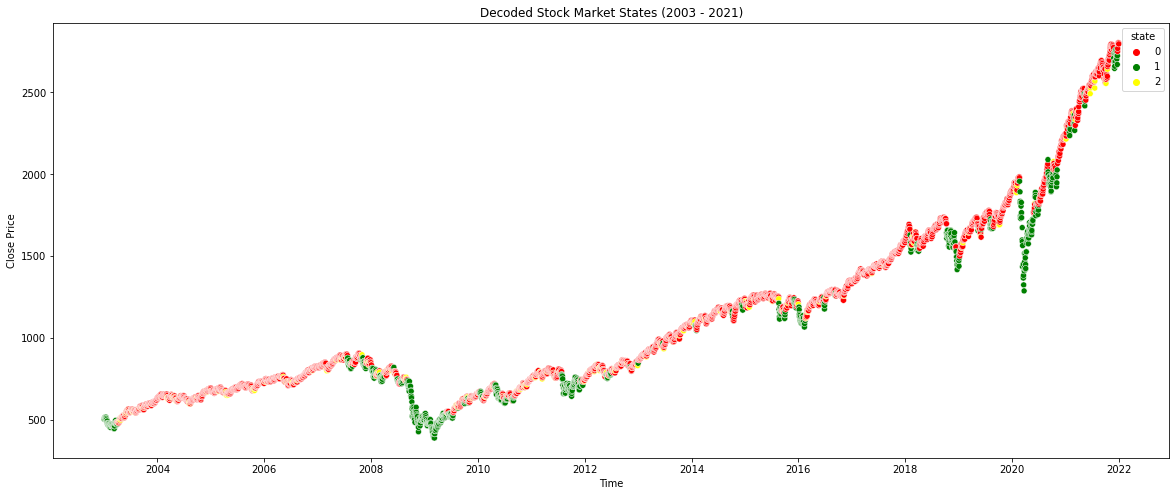

In [18]:
# Plot decoded states from 2003 to 2021
colors = {0:'red', 1:'green', 2:'yellow'}
plt.figure(figsize = (20,8))
sns.scatterplot(x = result.index, y = result['Close'], palette=colors, hue = result['state'])
plt.title('Decoded Stock Market States (2003 - 2021)')
plt.xlabel('Time')
plt.ylabel('Close Price')

In [19]:
# Map the states to -1,0,1 based on above plot
result['state'] = result['state'].map({0: 1, 1: -1,2: 0})
result

,Open,High,Low,Close,Adj Close,Volume,Return,state
Date,,,,,,,,
2003-01-02,489.489990,505.179993,489.489990,505.179993,505.179993,0,0.032054,-1
2003-01-03,505.179993,506.230011,502.100006,504.769989,504.769989,0,-0.000812,-1
2003-01-06,504.769989,517.530029,504.769989,516.039978,516.039978,0,0.022327,-1
2003-01-07,516.039978,516.650024,510.769989,512.450012,512.450012,0,-0.006957,-1
2003-01-08,512.450012,512.450012,504.529999,505.309998,505.309998,0,-0.013933,-1
...,...,...,...,...,...,...,...,...
2021-12-23,2750.840088,2776.620117,2750.840088,2768.360107,2768.360107,0,0.006490,1
2021-12-27,2769.340088,2803.879883,2769.340088,2803.739990,2803.739990,0,0.012780,1
2021-12-28,2803.899902,2813.590088,2795.709961,2798.350098,2798.350098,0,-0.001922,1


Text(0, 0.5, 'Close Price')

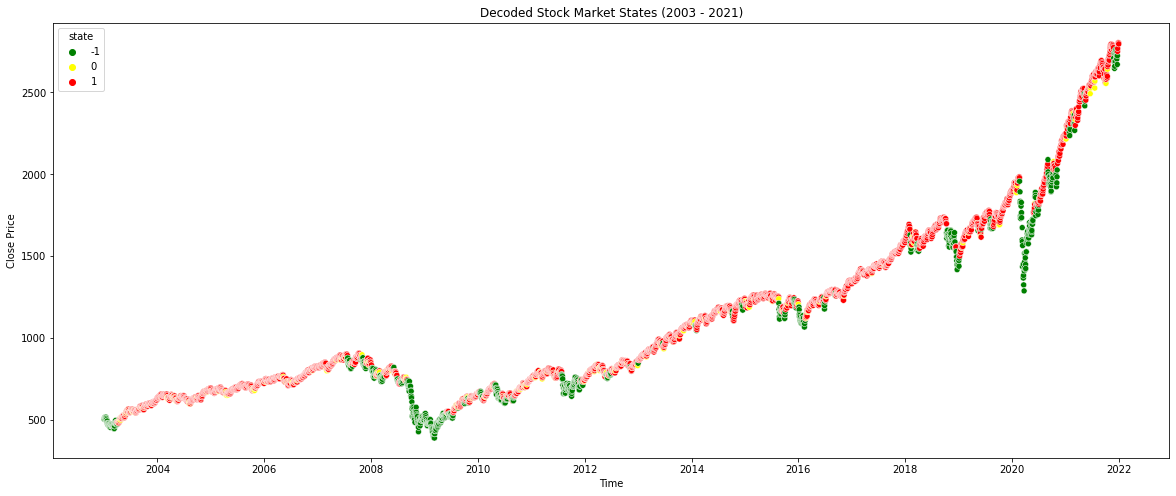

In [20]:
# Plot decoded states from 2003 to 2021 after mapping
colors = {1:'red', -1:'green', 0:'yellow'}
plt.figure(figsize = (20,8))
sns.scatterplot(x = result.index, y = result['Close'], palette=colors, hue = result['state'])
plt.title('Decoded Stock Market States (2003 - 2021)')
plt.xlabel('Time')
plt.ylabel('Close Price')

In [21]:
# Parameters needed for RandomizedSearch
xg_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'max_depth': [3, 4, 5]
        }

In [25]:
X_train, y_train = result.loc['2003-01-02':'2018-01-01',:]['Return'], result.loc['2003-01-02':'2018-01-01']['state']
X_test, y_test = result.loc['2018-01-01':'2022-01-01',:]['Return'], result.loc['2018-01-01':'2022-01-01']['state']


In [26]:
X_train.shape

(3776,)

In [27]:
y_train.shape

(3776,)

In [30]:
# Set X to be return and y to be state, the training period is 2003-2017 and testing period is 2018-2021 
# Fit XGBoost model
X_train, y_train = result.loc['2003-01-02':'2018-01-01',:]['Return'], result.loc['2003-01-02':'2018-01-01']['state']
X_test, y_test = result.loc['2018-01-01':'2022-01-01',:]['Return'], result.loc['2018-01-01':'2022-01-01']['state']

xg = XGBClassifier()
xg_random = RandomizedSearchCV(estimator = xg, param_distributions = xg_grid, n_iter = 100, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
xg_random.fit(X_train.to_frame(), y_train.to_frame())
params = xg_random.best_params_

model = XGBClassifier(**params).fit(X_train.to_frame(), y_train.to_frame())

y_pred = model.predict(X_test.to_frame())

result.loc['2018-01-01':'2022-01-01',['predict']] = y_pred.reshape(-1,1)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


In [31]:
# Print the predicted result from 2018 to 2021
result = result.loc['2018-01-01':'2022-01-01']
result

,Open,High,Low,Close,Adj Close,Volume,Return,state,predict
Date,,,,,,,,,
2018-01-02,1585.089966,1595.939941,1585.089966,1595.869995,1595.869995,0,0.008277,1,1.0
2018-01-03,1595.839966,1605.890015,1595.839966,1605.189941,1605.189941,0,0.005840,1,1.0
2018-01-04,1605.699951,1613.839966,1605.699951,1611.020020,1611.020020,0,0.003632,1,1.0
2018-01-05,1612.140015,1621.479980,1612.140015,1621.369995,1621.369995,0,0.006424,1,1.0
2018-01-08,1621.280029,1624.780029,1617.640015,1624.349976,1624.349976,0,0.001838,1,1.0
...,...,...,...,...,...,...,...,...,...
2021-12-23,2750.840088,2776.620117,2750.840088,2768.360107,2768.360107,0,0.006490,1,1.0
2021-12-27,2769.340088,2803.879883,2769.340088,2803.739990,2803.739990,0,0.012780,1,1.0
2021-12-28,2803.899902,2813.590088,2795.709961,2798.350098,2798.350098,0,-0.001922,1,1.0


Text(0, 0.5, 'Close Price')

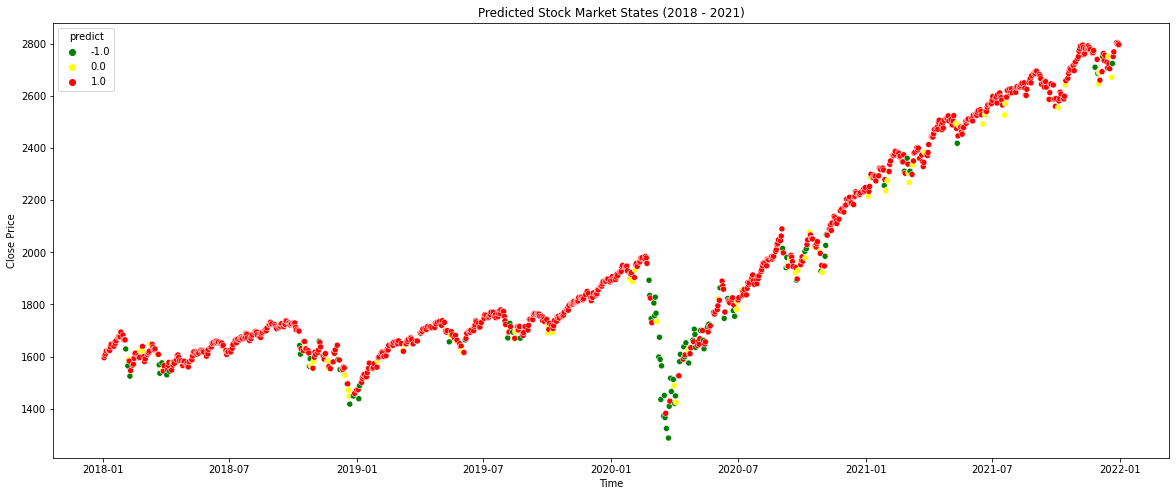

In [32]:
# Plot predicted states from 2018 to 2021
colors = {1:'red', -1:'green', 0:'yellow'}
plt.figure(figsize = (20,8))
sns.scatterplot(x = result.index, y = result['Close'], palette=colors, hue = result['predict'])
plt.title('Predicted Stock Market States (2018 - 2021)')
plt.xlabel('Time')
plt.ylabel('Close Price')

In [33]:
# define the function of checking the accuracy of decoded states and predicted states
def function(a, b):
    if a == b:
        return 1
    else:
        return 0

In [34]:
# Dataframe the checking results
result['bool'] = result.apply(lambda x : function(x['state'], x['predict']),axis = 1)
result

,Open,High,Low,Close,Adj Close,Volume,Return,state,predict,bool
Date,,,,,,,,,,
2018-01-02,1585.089966,1595.939941,1585.089966,1595.869995,1595.869995,0,0.008277,1,1.0,1
2018-01-03,1595.839966,1605.890015,1595.839966,1605.189941,1605.189941,0,0.005840,1,1.0,1
2018-01-04,1605.699951,1613.839966,1605.699951,1611.020020,1611.020020,0,0.003632,1,1.0,1
2018-01-05,1612.140015,1621.479980,1612.140015,1621.369995,1621.369995,0,0.006424,1,1.0,1
2018-01-08,1621.280029,1624.780029,1617.640015,1624.349976,1624.349976,0,0.001838,1,1.0,1
...,...,...,...,...,...,...,...,...,...,...
2021-12-23,2750.840088,2776.620117,2750.840088,2768.360107,2768.360107,0,0.006490,1,1.0,1
2021-12-27,2769.340088,2803.879883,2769.340088,2803.739990,2803.739990,0,0.012780,1,1.0,1
2021-12-28,2803.899902,2813.590088,2795.709961,2798.350098,2798.350098,0,-0.001922,1,1.0,1


Text(0, 0.5, 'Close Price')

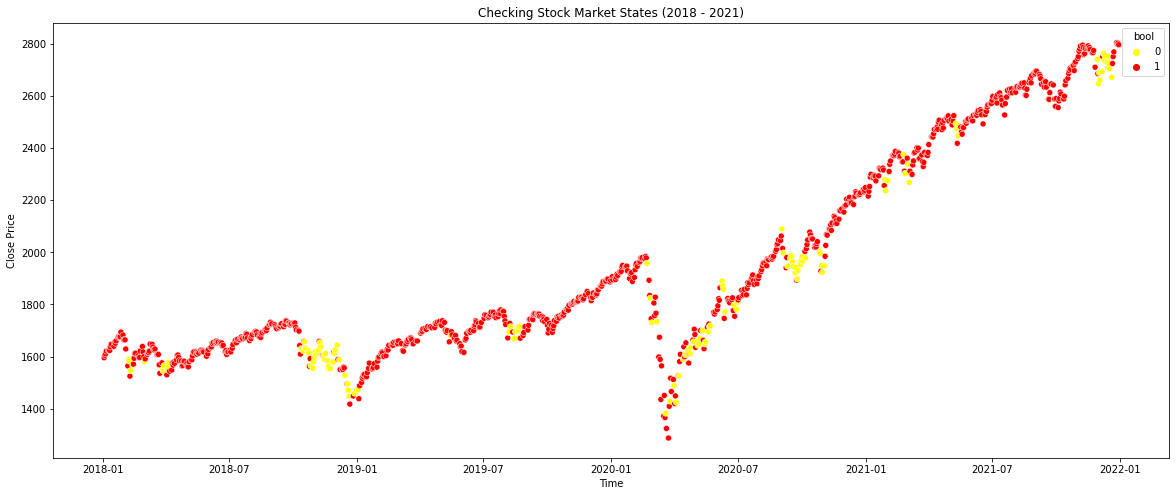

In [35]:
# Plot the checking results from 2018 to 2021 
colors = {1:'red', 0:'yellow'}
plt.figure(figsize = (20,8))
sns.scatterplot(x = result.index, y = result['Close'], palette=colors, hue = result['bool'])
plt.title('Checking Stock Market States (2018 - 2021)')
plt.xlabel('Time')
plt.ylabel('Close Price')

In [36]:
# Print the model's f1 score
f1 = f1_score(y_pred,y_test, average='weighted')
f1

0.870954482240297

In [37]:
# Print best params of XGBoost model
params

{'gamma': 2, 'max_depth': 3, 'min_child_weight': 5}

In [38]:
# Set strategy
class PandasData(PandasData):

    '''
    The ``dataname`` parameter inherited from ``feed.DataBase`` is the pandas
    DataFrame
    '''
    lines = ('state',)
    params = (
        ('datetime', 0),
        ('high', 'High'),
        ('low', 'Low'),
        ('close', 'Close'),
        ('volume', None),
        ('openinterest', None),
        ('state', 8),
    )
    datafields = PandasData.datafields + (['state'])

# Strategy based on market states
class MarketStatus(bt.Strategy): 


    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)

    def __init__(self):
        self.dataclose = self.datas[0].close

        # Order variable will contain ongoing order details/status
        self.order = None

        # Instantiate market status
        self.state = self.datas[0].state

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # An active Buy/Sell order has been submitted/accepted - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, {order.executed.price:.2f}')
            elif order.issell():
                self.log(f'SELL EXECUTED, {order.executed.price:.2f}')
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Reset orders
        self.order = None

    def next(self):

        # Check for open orders
        if self.order:
            return
        
        if self.state[0] == 1:
            if not self.position:
                self.log(f'BUY CREATE {self.dataclose[0]:2f} {self.state[0]:2f}')
                self.order = self.buy()
            elif self.position.size < 0: # already have a sell order
                self.order = self.close()
                self.log(f'CLOSE CREATE {self.dataclose[0]:2f}')
                self.log(f'BUY CREATE {self.dataclose[0]:2f} {self.state[0]:2f}')
                self.order = self.buy()
            elif self.position.size > 0: # already have a buy order
                # Check the period of current states
                if len(self) == (self.bar_executed + 5):
                    self.log(f'BUY CREATE {self.dataclose[0]:2f} {self.state[0]:2f}')
                    self.order = self.buy()
                    self.log('Chase')
                elif len(self) >= (self.bar_executed + 15):
                    self.order = self.close()
                    self.log(f'CLOSE CREATE {self.dataclose[0]:2f}')
                else:
                    pass
            else:
                pass
        
        elif self.state[0] == -1:
            if not self.position:           
                self.log(f'SELL CREATE {self.dataclose[0]:2f} {self.state[0]:2f}')
                self.order = self.sell()
            elif self.position.size > 0: # already have a buy order             
                self.order = self.close()
                self.log(f'CLOSE CREATE {self.dataclose[0]:2f}')
                self.log(f'SELL CREATE {self.dataclose[0]:2f} {self.state[0]:2f}')
                self.order = self.sell()
            elif self.position.size < 0: # already have a sell order
                if len(self) == (self.bar_executed + 5):
                    self.log(f'SELL CREATE {self.dataclose[0]:2f} {self.state[0]:2f}')
                    self.order = self.sell()
                elif len(self) >= (self.bar_executed + 15):
                    self.order = self.close()
                    self.log(f'CLOSE CREATE {self.dataclose[0]:2f}')
                else:
                    pass

            else:
                pass
        
        else:
            if not self.position:
                pass
            else:
                self.log(f'Hold {self.dataclose[0]:2f} {self.state[0]:2f}')

# Benchmark strategy - BuyAndHold
class BuyAndHold(bt.Strategy):

    def log(self,txt,dt=None):
        dt = dt or self.datas[0].datetime.date(0)
    
    def __init__(self):
        self.dataclose = self.datas[0].close

        self.order = None
        
    def notify_order(self,order):
        if order.status in [order.Submitted, order.Accepted]:
			# An active Buy/Sell order has been submitted/accepted - Nothing to do
            return
        
        # Check if an order has been completed
		# Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, {order.executed.price:.2f}')
            elif order.issell():
                self.log(f'SELL EXECUTED, {order.executed.price:.2f}')
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
    def next(self):
        # Check for open orders
        if self.order:
            return
        self.log(f'BUY CREATE {self.dataclose[0]:2f}')
        self.order = self.buy()

In [39]:
def run_cerebro(df,strategy):
    
    df = df.reset_index()
    state_column = df.shape[1] - 2
    # Instantiate Cerebro engine
    cerebro = bt.Cerebro()

    data = PandasData(
        dataname = df,
        fromdate=datetime.datetime(2018, 1, 2),
        todate=datetime.datetime(2021, 12, 30),
        datetime = 0,
        open = 1,
        high = 2,
        low = 3,
        close = 4,
        state = state_column,
    )

    # Add data to Cerebro
    cerebro.adddata(data)
    # Add strategy to Cerebro
    cerebro.addstrategy(strategy)

    # Default position size
    cerebro.addsizer(bt.sizers.SizerFix, stake=1)

    # Add analytics to Cerebro
    cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='SharpeRatio')
    cerebro.addanalyzer(btanalyzers.AnnualReturn, _name='AnnualReturn')
    cerebro.addanalyzer(btanalyzers.DrawDown, _name='DrawDown')
    cerebro.addanalyzer(btanalyzers.TimeDrawDown, _name='TimeDrawDown')
    cerebro.addanalyzer(btanalyzers.PositionsValue, _name='PositionsValue')
    cerebro.addanalyzer(btanalyzers.LogReturnsRolling, _name='LogReturnsRolling')
    cerebro.addanalyzer(btanalyzers.PeriodStats, _name='PeriodStats')
    cerebro.addanalyzer(btanalyzers.Returns, _name='Returns')
    cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name='TradeAnalyzer')
    cerebro.addanalyzer(btanalyzers.Transactions, _name='Transactions')

    # Run Cerebro engine
    start_portfolio_value = cerebro.broker.getvalue()

    # cerebro.run()
    thestrats = cerebro.run()
    thestrat = thestrats[0]

    end_portfolio_value = cerebro.broker.getvalue()
    pnl = end_portfolio_value - start_portfolio_value

    print(f'Starting Portfolio Value: {start_portfolio_value:2f}')
    print(f'Final Portfolio Value: {end_portfolio_value:2f}')
    print(f'PnL: {pnl:.2f}\n')


    sharpe = thestrat.analyzers.SharpeRatio.get_analysis()['sharperatio']

    return pnl, sharpe

In [40]:
# PnL and Sharpe Ratio using MarketStatus starategy
pnl, sharpe = run_cerebro(result, MarketStatus)

Starting Portfolio Value: 10000.000000
Final Portfolio Value: 13442.122559
PnL: 3442.12



In [41]:
print('pnl: ', pnl)
print('sharpe: ', sharpe)

pnl:  3442.12255859375
sharpe:  0.9039798769778024


In [42]:
# PnL and Sharpe Ratio using BuyAndHold starategy
pnl, sharpe = run_cerebro(result, BuyAndHold)
print('pnl: ', pnl)
print('sharpe: ', sharpe)

Starting Portfolio Value: 10000.000000
Final Portfolio Value: 11200.069946
PnL: 1200.07

pnl:  1200.0699462890625
sharpe:  0.7728328561630216
